# Partie 4

## Figure 1

A demonstration of fast adversarial example generation applied to GoogLeNet (Szegedy et al., 2014a) on ImageNet. By adding an imperceptibly small vector whose elements are equal to the sign of the elements of the gradient of the cost function with respect to the input, we can change GoogLeNet’s classification of the image. Here our epsilon of .007 corresponds to the magnitude of the smallest bit of an 8 bit image encoding after GoogLeNet’s conversion to real numbers.

In [ ]:
## code à implémenter une fois que l'on aura accès à ImageNET

## Choix de l'optimisateur

We find that this method reliably causes a wide variety of models to misclassify their input. See Fig. 1 for a demonstration on ImageNet. We find that using epsilon = 0.25, we cause a shallow softmax classifier to have an error rate of 99.9% with an average confidence of 79.3% on the MNIST test set1. 

(test avec optimisateur adam et optimisateur SGD avec momentum)

Epoch [1/20], Loss: 0.2227339434218027
Epoch [2/20], Loss: 0.12808437365914452
Epoch [3/20], Loss: 0.1104751846158325
Epoch [4/20], Loss: 0.0981244022347607
Epoch [5/20], Loss: 0.09136854500668908
Epoch [6/20], Loss: 0.08528866298383597
Epoch [7/20], Loss: 0.0776622329566478
Epoch [8/20], Loss: 0.07491360101018543
Epoch [9/20], Loss: 0.07389294644151471
Epoch [10/20], Loss: 0.06824332761048385
Epoch [11/20], Loss: 0.07109093182132008
Epoch [12/20], Loss: 0.0655947696621098
Epoch [13/20], Loss: 0.06418576587663419
Epoch [14/20], Loss: 0.06382677291543541
Epoch [15/20], Loss: 0.0633508421908796
Epoch [16/20], Loss: 0.060012284212396634
Epoch [17/20], Loss: 0.05489488325326378
Epoch [18/20], Loss: 0.05228418010751045
Epoch [19/20], Loss: 0.057935824557533155
Epoch [20/20], Loss: 0.05046853992359953
Accuracy on adversarial examples: 28.108333333333334%
Average probability assigned to incorrect predictions: 94.83%


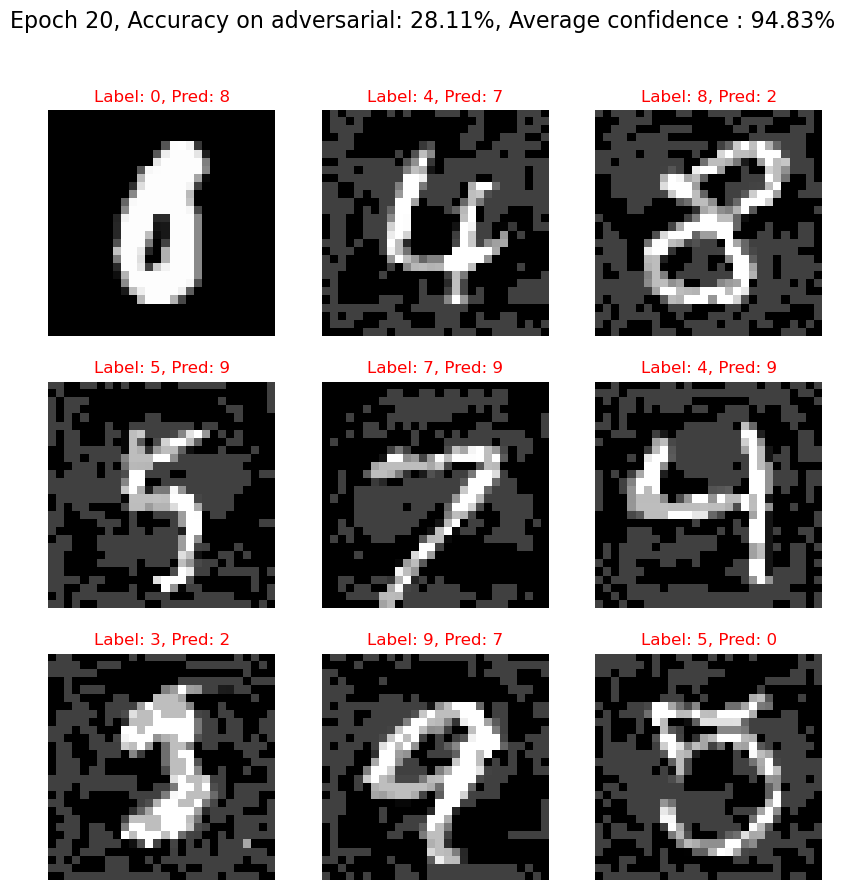

In [ ]:
# @title Bonne version, rnn simple avec epsilon = 0.25, et optimisateur : adam
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    # Assurez-vous que les gradients sont activés pour les images
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Clipper les valeurs des pixels dans [0, 1]

    return adversarial_images

# Classe du modèle (réseau neuronal simple)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Aplatir l'image en vecteur
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Charger les données MNIST
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()  # Assurez-vous que le modèle est en mode évaluation

    correct = 0
    total = 0
    incorrect_probs = []

    for images, labels in train_loader:
        # Ensure images require gradients before FGSM
        images = images.clone().detach().requires_grad_(True)

        # La génération d'exemples adversariaux nécessite des gradients
        # images.requires_grad = True  # Activation des gradients # No longer needed here
        adversarial_images = FGSM(model, images, labels, epsilon)

        # Tester sur des exemples adversariaux
        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)  # Convertir les sorties en probabilités
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

       # Collecter les probabilités des mauvaises prédictions
        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:  # Si la prédiction est incorrecte
                incorrect_probs.append(probs[i, predicted[i]].item())

    # Calcul de la précision
    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')

    # Calcul de la probabilité moyenne des mauvaises prédictions
    if incorrect_probs:
        avg_incorrect_prob = np.mean(incorrect_probs)*100
        print(f'Average probability assigned to incorrect predictions: {avg_incorrect_prob:.2f}%')
    else:
        avg_incorrect_prob = 0
        print('No incorrect predictions to calculate average probability.')

    return accuracy, avg_incorrect_prob

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%, Average confidence : {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    # Charger les données (avec uniquement des 3 et des 7)
    train_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = SimpleNN()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy, avg_incorrect_prob = test_on_adversarial_data(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


Epoch [1/20], Loss: 0.4679483614369496
Epoch [2/20], Loss: 0.23116250382239883
Epoch [3/20], Loss: 0.17200228146541474
Epoch [4/20], Loss: 0.13705326898146603
Epoch [5/20], Loss: 0.11400087568750068
Epoch [6/20], Loss: 0.09783750313169348
Epoch [7/20], Loss: 0.08566852192928605
Epoch [8/20], Loss: 0.07596320931269511
Epoch [9/20], Loss: 0.06838989340122352
Epoch [10/20], Loss: 0.06175652496528619
Epoch [11/20], Loss: 0.056475122685609724
Epoch [12/20], Loss: 0.051304522580576384
Epoch [13/20], Loss: 0.04724521680411373
Epoch [14/20], Loss: 0.043546732993665405
Epoch [15/20], Loss: 0.03966524871239967
Epoch [16/20], Loss: 0.03706724080554982
Epoch [17/20], Loss: 0.03398947476564265
Epoch [18/20], Loss: 0.031528017775310495
Epoch [19/20], Loss: 0.029110271175866568
Epoch [20/20], Loss: 0.02709328443686198
Accuracy on adversarial examples: 0.6133333333333333%
Average probability assigned to incorrect predictions: 92.16%


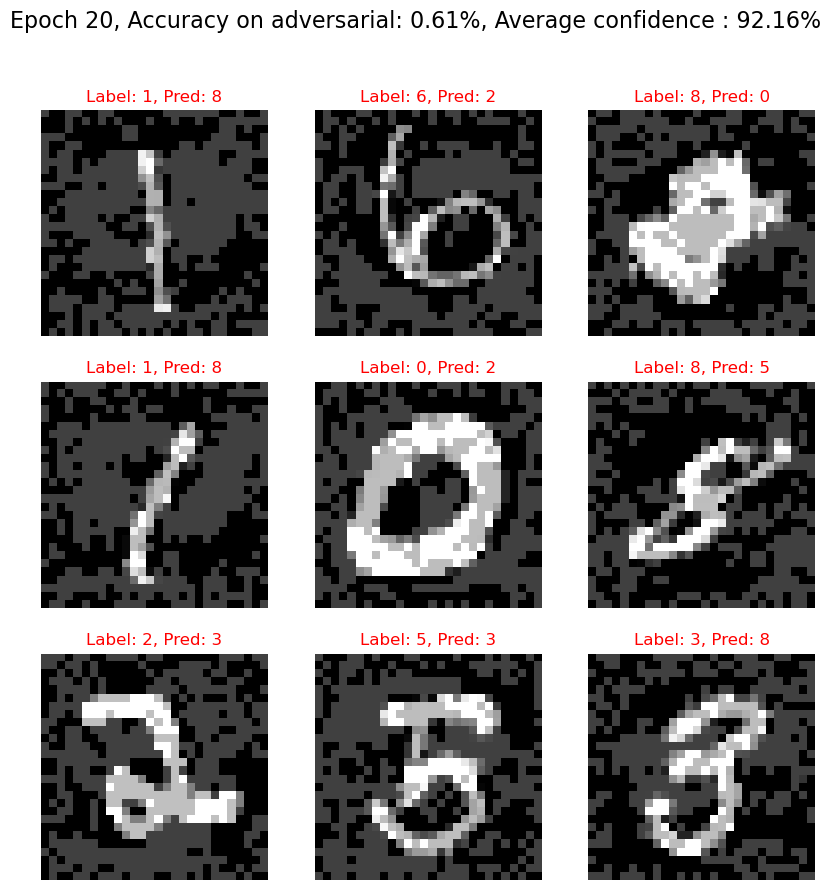

In [ ]:
# @title Bonne version, rnn simple avec epsilon = 0.25, et optimisateur : SGD avec momentum (=0.9)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    # Assurez-vous que les gradients sont activés pour les images
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Clipper les valeurs des pixels dans [0, 1]

    return adversarial_images

# Classe du modèle (réseau neuronal simple)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Aplatir l'image en vecteur
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Charger les données MNIST
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()  # Assurez-vous que le modèle est en mode évaluation

    correct = 0
    total = 0
    incorrect_probs = []

    for images, labels in train_loader:
        # Ensure images require gradients before FGSM
        images = images.clone().detach().requires_grad_(True)

        # La génération d'exemples adversariaux nécessite des gradients
        # images.requires_grad = True  # Activation des gradients # No longer needed here
        adversarial_images = FGSM(model, images, labels, epsilon)

        # Tester sur des exemples adversariaux
        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)  # Convertir les sorties en probabilités
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

       # Collecter les probabilités des mauvaises prédictions
        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:  # Si la prédiction est incorrecte
                incorrect_probs.append(probs[i, predicted[i]].item())

    # Calcul de la précision
    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')

    # Calcul de la probabilité moyenne des mauvaises prédictions
    if incorrect_probs:
        avg_incorrect_prob = np.mean(incorrect_probs)*100
        print(f'Average probability assigned to incorrect predictions: {avg_incorrect_prob:.2f}%')
    else:
        avg_incorrect_prob = 0
        print('No incorrect predictions to calculate average probability.')

    return accuracy, avg_incorrect_prob

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%, Average confidence : {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    # Charger les données (avec uniquement des 3 et des 7)
    train_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = SimpleNN()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy, avg_incorrect_prob = test_on_adversarial_data(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


## Classificateur Softmax superficiel, optimisateur : SGD avec momentum

We find that this method reliably causes a wide variety of models to misclassify their input. See Fig. 1 for a demonstration on ImageNet. We find that using epsilon = 0.25, we cause a shallow softmax classifier to have an error rate of 99.9% with an average confidence of 79.3% on the MNIST test set1. 

(test avec optimizateur Adam et SGD avec momentum)

Epoch [1/20], Loss: 0.3587071828282019
Epoch [2/20], Loss: 0.30677901797775015
Epoch [3/20], Loss: 0.3030715127215425
Epoch [4/20], Loss: 0.29414061782980905
Epoch [5/20], Loss: 0.28929743388576357
Epoch [6/20], Loss: 0.2936288654081412
Epoch [7/20], Loss: 0.28814769088864517
Epoch [8/20], Loss: 0.2870423907696057
Epoch [9/20], Loss: 0.28347664344896956
Epoch [10/20], Loss: 0.2852281049660433
Epoch [11/20], Loss: 0.2829664480616289
Epoch [12/20], Loss: 0.282386988333897
Epoch [13/20], Loss: 0.282051395942598
Epoch [14/20], Loss: 0.2800754453184635
Epoch [15/20], Loss: 0.28015095360878944
Epoch [16/20], Loss: 0.2799984830350224
Epoch [17/20], Loss: 0.28023346304607544
Epoch [18/20], Loss: 0.27876302600701225
Epoch [19/20], Loss: 0.2777435763586146
Epoch [20/20], Loss: 0.27912240259762383
Accuracy on adversarial examples: 0.0%
Average probability assigned to incorrect predictions: 98.97%


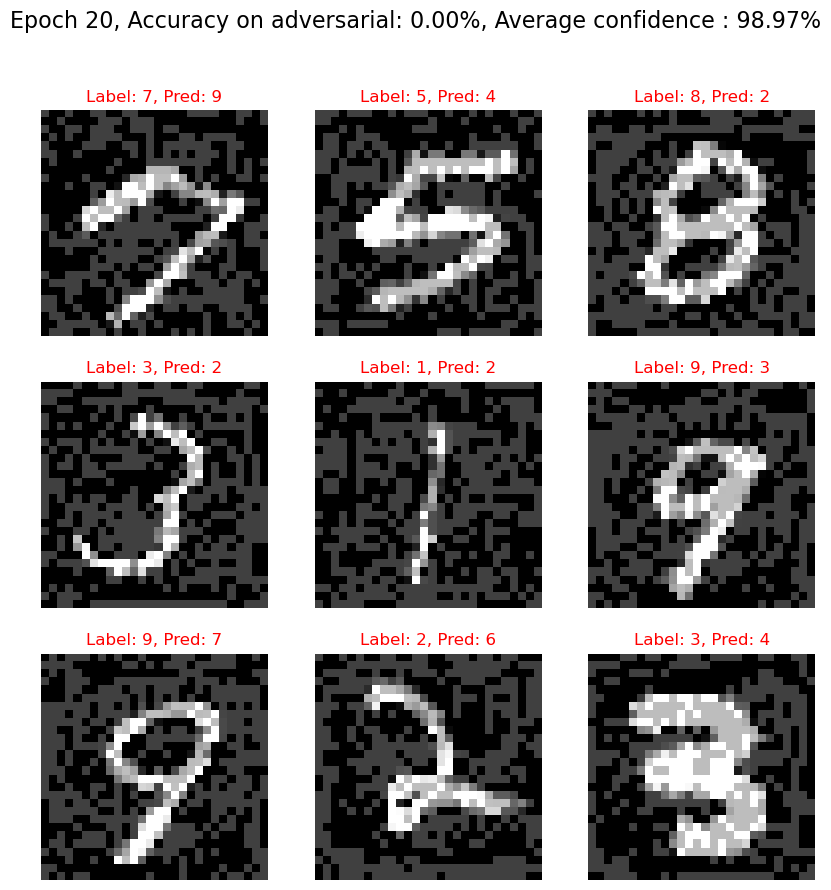

In [44]:
# @title bonne version, Shallow Softmax Classifier avec epsilon = 0.25, et optimisateur : Adam
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    # s'assurer que les gradients sont activés pour les images
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Clipper les valeurs des pixels dans [0, 1]

    return adversarial_images

# Classe du modèle (shallow softmax classifier)
class ShallowSoftmaxClassifier(nn.Module):
    def __init__(self):
        super(ShallowSoftmaxClassifier, self).__init__()
        # Une seule couche linéaire reliant les pixels d'entrée aux 10 classes
        self.fc = nn.Linear(28 * 28, 10)  # MNIST images de 28x28 pixels

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplatir l'image en vecteur
        x = self.fc(x)
        return x  # Pas de fonction d'activation ici, CrossEntropyLoss inclut softmax
    
# Charger les données MNIST
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()  # Assurez-vous que le modèle est en mode évaluation

    correct = 0
    total = 0
    incorrect_probs = []

    for images, labels in train_loader:
        # Ensure images require gradients before FGSM
        images = images.clone().detach().requires_grad_(True)

        # La génération d'exemples adversariaux nécessite des gradients
        # images.requires_grad = True  # Activation des gradients # No longer needed here
        adversarial_images = FGSM(model, images, labels, epsilon)

        # Tester sur des exemples adversariaux
        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)  # Convertir les sorties en probabilités
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

       # Collecter les probabilités des mauvaises prédictions
        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:  # Si la prédiction est incorrecte
                incorrect_probs.append(probs[i, predicted[i]].item())

    # Calcul de la précision
    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')

    # Calcul de la probabilité moyenne des mauvaises prédictions
    if incorrect_probs:
        avg_incorrect_prob = np.mean(incorrect_probs)*100
        print(f'Average probability assigned to incorrect predictions: {avg_incorrect_prob:.2f}%')
    else:
        avg_incorrect_prob = 0
        print('No incorrect predictions to calculate average probability.')

    return accuracy, avg_incorrect_prob

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%, Average confidence : {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    # Charger les données (avec uniquement des 3 et des 7)
    train_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = ShallowSoftmaxClassifier()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy, avg_incorrect_prob = test_on_adversarial_data(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


Epoch [1/20], Loss: 0.48285688898329543
Epoch [2/20], Loss: 0.33701378400169457
Epoch [3/20], Loss: 0.31385348415546327
Epoch [4/20], Loss: 0.3023554575579888
Epoch [5/20], Loss: 0.2942320279745278
Epoch [6/20], Loss: 0.2887308493272455
Epoch [7/20], Loss: 0.28452451554919356
Epoch [8/20], Loss: 0.2803739167289185
Epoch [9/20], Loss: 0.27792397592621826
Epoch [10/20], Loss: 0.2752891561862375
Epoch [11/20], Loss: 0.2735934865071194
Epoch [12/20], Loss: 0.2712697515577904
Epoch [13/20], Loss: 0.2700490083362756
Epoch [14/20], Loss: 0.2684383188991913
Epoch [15/20], Loss: 0.2673752269884353
Epoch [16/20], Loss: 0.2656619415195512
Epoch [17/20], Loss: 0.2645417346771973
Epoch [18/20], Loss: 0.2635950752571702
Epoch [19/20], Loss: 0.2626389383411865
Epoch [20/20], Loss: 0.26184561158389424
Accuracy on adversarial examples: 0.011666666666666667%
Average probability assigned to incorrect predictions: 90.55%


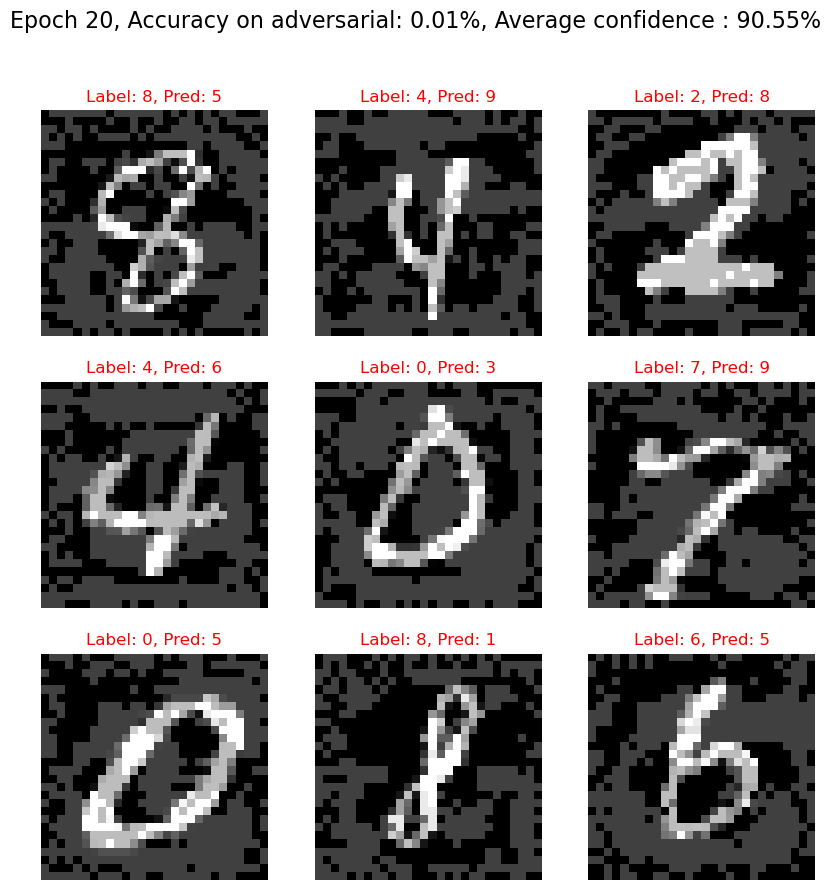

In [ ]:
# @title bonne version, Shallow Softmax Classifier avec epsilon = 0.25, et optimisateur : SGD avec momentum (=0.9)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    # s'assurer que les gradients sont activés pour les images
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Clipper les valeurs des pixels dans [0, 1]

    return adversarial_images

# Classe du modèle (shallow softmax classifier)
class ShallowSoftmaxClassifier(nn.Module):
    def __init__(self):
        super(ShallowSoftmaxClassifier, self).__init__()
        # Une seule couche linéaire reliant les pixels d'entrée aux 10 classes
        self.fc = nn.Linear(28 * 28, 10)  # MNIST images de 28x28 pixels

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplatir l'image en vecteur
        x = self.fc(x)
        return x  # Pas de fonction d'activation ici, CrossEntropyLoss inclut softmax
    
# Charger les données MNIST
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()  # Assurez-vous que le modèle est en mode évaluation

    correct = 0
    total = 0
    incorrect_probs = []

    for images, labels in train_loader:
        # Ensure images require gradients before FGSM
        images = images.clone().detach().requires_grad_(True)

        # La génération d'exemples adversariaux nécessite des gradients
        # images.requires_grad = True  # Activation des gradients # No longer needed here
        adversarial_images = FGSM(model, images, labels, epsilon)

        # Tester sur des exemples adversariaux
        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)  # Convertir les sorties en probabilités
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

       # Collecter les probabilités des mauvaises prédictions
        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:  # Si la prédiction est incorrecte
                incorrect_probs.append(probs[i, predicted[i]].item())

    # Calcul de la précision
    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')

    # Calcul de la probabilité moyenne des mauvaises prédictions
    if incorrect_probs:
        avg_incorrect_prob = np.mean(incorrect_probs)*100
        print(f'Average probability assigned to incorrect predictions: {avg_incorrect_prob:.2f}%')
    else:
        avg_incorrect_prob = 0
        print('No incorrect predictions to calculate average probability.')

    return accuracy, avg_incorrect_prob

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%, Average confidence : {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    # Charger les données (avec uniquement des 3 et des 7)
    train_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = ShallowSoftmaxClassifier()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy, avg_incorrect_prob = test_on_adversarial_data(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


## Réseau Maxout, avec optimisateur : SGD avec momentum

In the same setting, a maxout network misclassifies 89.4% of our adversarial examples with an average confidence of 97.6%.

(test avec optimizateur Adam et SGD avec momentum)

Epoch [1/20], Loss: 0.35628538477574107
Epoch [2/20], Loss: 0.2832605241851108
Epoch [3/20], Loss: 0.3083498011270763
Epoch [4/20], Loss: 0.31100153710446876
Epoch [5/20], Loss: 0.31068999367649525
Epoch [6/20], Loss: 0.27526397176751355
Epoch [7/20], Loss: 0.2982578606126501
Epoch [8/20], Loss: 0.2972106563281978
Epoch [9/20], Loss: 0.29494506298436246
Epoch [10/20], Loss: 0.30964086499825083
Epoch [11/20], Loss: 0.2950220444068557
Epoch [12/20], Loss: 0.2684384090455543
Epoch [13/20], Loss: 0.25720469126655304
Epoch [14/20], Loss: 0.31790098370714304
Epoch [15/20], Loss: 0.2792730559316212
Epoch [16/20], Loss: 0.2713517146316053
Epoch [17/20], Loss: 0.2901061306199608
Epoch [18/20], Loss: 0.2654442465697744
Epoch [19/20], Loss: 0.27127410286814985
Epoch [20/20], Loss: 0.2567230215879559
Accuracy on adversarial examples: 66.59166666666667%
Average probability assigned to incorrect predictions: 99.99%


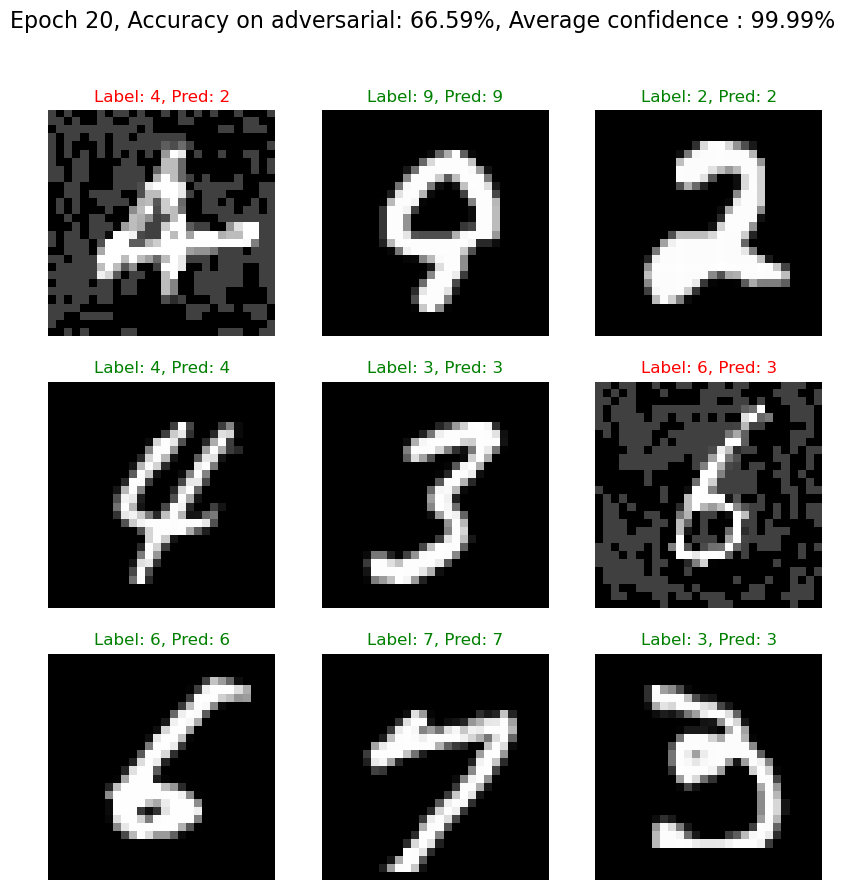

In [43]:
# @title bonne version, Maxout Network avec epsilon = 0.25, et optimisateur : Adam
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    # s'assurer que les gradients sont activés pour les images
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Clipper les valeurs des pixels dans [0, 1]

    return adversarial_images

# Classe du modèle: maxout
class MaxoutNN(nn.Module):
    def __init__(self, num_pieces=2):
        super(MaxoutNN, self).__init__()
        self.maxout1 = Maxout(28 * 28, 128, num_pieces)  # Première couche Maxout
        self.maxout2 = Maxout(128, 10, num_pieces)       # Deuxième couche Maxout (sortie)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplatir l'image en vecteur
        x = self.maxout1(x)      # Première couche Maxout
        x = self.maxout2(x)      # Deuxième couche Maxout
        return x

class Maxout(nn.Module):
    def __init__(self, in_features, out_features, num_pieces):
        super(Maxout, self).__init__()
        self.num_pieces = num_pieces
        self.out_features = out_features
        self.linear = nn.Linear(in_features, out_features * num_pieces)

    def forward(self, x):
        # Calculer les activations linéaires
        shape = x.size(0), self.out_features, self.num_pieces
        x = self.linear(x)
        x = x.view(*shape)
        return x.max(dim=2)[0]  # Prend le maximum sur les morceaux

# Charger les données MNIST
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()  # Assurez-vous que le modèle est en mode évaluation

    correct = 0
    total = 0
    incorrect_probs = []

    for images, labels in train_loader:
        # Ensure images require gradients before FGSM
        images = images.clone().detach().requires_grad_(True)

        # La génération d'exemples adversariaux nécessite des gradients
        # images.requires_grad = True  # Activation des gradients # No longer needed here
        adversarial_images = FGSM(model, images, labels, epsilon)

        # Tester sur des exemples adversariaux
        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)  # Convertir les sorties en probabilités
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

       # Collecter les probabilités des mauvaises prédictions
        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:  # Si la prédiction est incorrecte
                incorrect_probs.append(probs[i, predicted[i]].item())

    # Calcul de la précision
    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')

    # Calcul de la probabilité moyenne des mauvaises prédictions
    if incorrect_probs:
        avg_incorrect_prob = np.mean(incorrect_probs) * 100
        print(f'Average probability assigned to incorrect predictions: {avg_incorrect_prob:.2f}%')
    else:
        avg_incorrect_prob = 0
        print('No incorrect predictions to calculate average probability.')

    return accuracy, avg_incorrect_prob

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%, Average confidence : {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    # Charger les données (avec uniquement des 3 et des 7)
    train_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = MaxoutNN(num_pieces=2)  # Réseau complet avec deux couches Maxout
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy, avg_incorrect_prob = test_on_adversarial_data(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


Epoch [1/20], Loss: 0.41648553415084444
Epoch [2/20], Loss: 0.17484295763758453
Epoch [3/20], Loss: 0.12460868939884436
Epoch [4/20], Loss: 0.09887975427721228
Epoch [5/20], Loss: 0.08147864287762817
Epoch [6/20], Loss: 0.06886202018104319
Epoch [7/20], Loss: 0.059410179105859356
Epoch [8/20], Loss: 0.05185181591143486
Epoch [9/20], Loss: 0.045929410199481824
Epoch [10/20], Loss: 0.041083032106444525
Epoch [11/20], Loss: 0.03622730879454629
Epoch [12/20], Loss: 0.032208646201952566
Epoch [13/20], Loss: 0.029222137870208453
Epoch [14/20], Loss: 0.026090321039953734
Epoch [15/20], Loss: 0.02346011624447624
Epoch [16/20], Loss: 0.021085673728327294
Epoch [17/20], Loss: 0.019235765721439434
Epoch [18/20], Loss: 0.017513522996566198
Epoch [19/20], Loss: 0.015936301806187037
Epoch [20/20], Loss: 0.014463980600529754
Accuracy on adversarial examples: 1.2516666666666667%
Average probability assigned to incorrect predictions: 94.76%


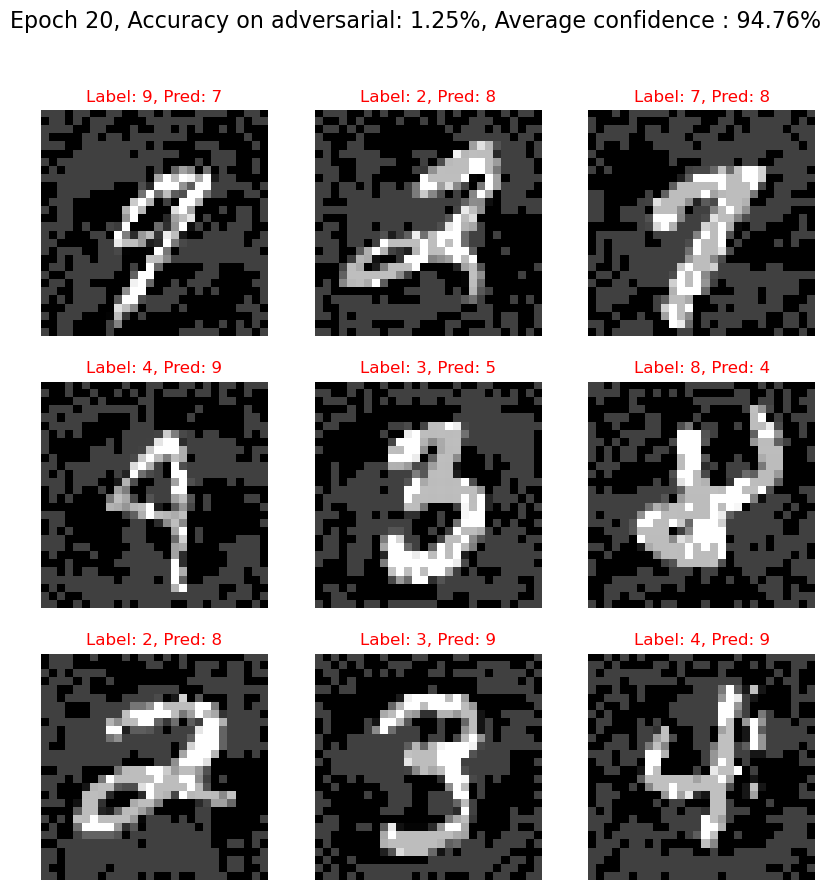

In [41]:
# @title bonne version, Maxout Network avec epsilon = 0.25, et optimisateur : SGD avec momentum (=0.9)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    # s'assurer que les gradients sont activés pour les images
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Clipper les valeurs des pixels dans [0, 1]

    return adversarial_images

# Classe du modèle: maxout
class MaxoutNN(nn.Module):
    def __init__(self, num_pieces=2):
        super(MaxoutNN, self).__init__()
        self.maxout1 = Maxout(28 * 28, 128, num_pieces)  # Première couche Maxout
        self.maxout2 = Maxout(128, 10, num_pieces)       # Deuxième couche Maxout (sortie)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplatir l'image en vecteur
        x = self.maxout1(x)      # Première couche Maxout
        x = self.maxout2(x)      # Deuxième couche Maxout
        return x

class Maxout(nn.Module):
    def __init__(self, in_features, out_features, num_pieces):
        super(Maxout, self).__init__()
        self.num_pieces = num_pieces
        self.out_features = out_features
        self.linear = nn.Linear(in_features, out_features * num_pieces)

    def forward(self, x):
        # Calculer les activations linéaires
        shape = x.size(0), self.out_features, self.num_pieces
        x = self.linear(x)
        x = x.view(*shape)
        return x.max(dim=2)[0]  # Prend le maximum sur les morceaux

# Charger les données MNIST
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()  # Assurez-vous que le modèle est en mode évaluation

    correct = 0
    total = 0
    incorrect_probs = []

    for images, labels in train_loader:
        # Ensure images require gradients before FGSM
        images = images.clone().detach().requires_grad_(True)

        # La génération d'exemples adversariaux nécessite des gradients
        # images.requires_grad = True  # Activation des gradients # No longer needed here
        adversarial_images = FGSM(model, images, labels, epsilon)

        # Tester sur des exemples adversariaux
        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)  # Convertir les sorties en probabilités
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

       # Collecter les probabilités des mauvaises prédictions
        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:  # Si la prédiction est incorrecte
                incorrect_probs.append(probs[i, predicted[i]].item())

    # Calcul de la précision
    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')

    # Calcul de la probabilité moyenne des mauvaises prédictions
    if incorrect_probs:
        avg_incorrect_prob = np.mean(incorrect_probs) * 100
        print(f'Average probability assigned to incorrect predictions: {avg_incorrect_prob:.2f}%')
    else:
        avg_incorrect_prob = 0
        print('No incorrect predictions to calculate average probability.')

    return accuracy, avg_incorrect_prob

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%, Average confidence : {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    # Charger les données (avec uniquement des 3 et des 7)
    train_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = MaxoutNN(num_pieces=2)  # Réseau complet avec deux couches Maxout
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy, avg_incorrect_prob = test_on_adversarial_data(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


## Réseau maxout convolutionnel, avec données prétraitées de CIFAR-10  

Similarly, using epsilon = 0.1, we obtain an error rate of 87.15% and an average probability of 96.6% assigned to the incorrect labels when using a convolutional maxout network on a preprocessed version of the CIFAR-10 (Krizhevsky & Hinton, 2009) test set2.

(test avec optimizateur Adam et SGD avec momentum)

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Loss: 1.3072098979864584
Epoch [2/20], Loss: 0.919343237681767
Epoch [3/20], Loss: 0.7395930094715885
Epoch [4/20], Loss: 0.5863934169949778
Epoch [5/20], Loss: 0.4380758153965406
Epoch [6/20], Loss: 0.2988623769291679
Epoch [7/20], Loss: 0.19283201343968243
Epoch [8/20], Loss: 0.11964199986175426
Epoch [9/20], Loss: 0.09110588090889671
Epoch [10/20], Loss: 0.07344055065022939
Epoch [11/20], Loss: 0.06869399098648458
Epoch [12/20], Loss: 0.06091997875650997
Epoch [13/20], Loss: 0.05930643651457003
Epoch [14/20], Loss: 0.047130638547866935
Epoch [15/20], Loss: 0.045364486673773005
Epoch [16/20], Loss: 0.048624209831724816
Epoch [17/20], Loss: 0.03649795975196985
Epoch [18/20], Loss: 0.04378654325836162
Epoch [19/20], Loss: 0.04603128343292981
Epoch [20/20], Loss: 0.04292276745026126
Accuracy on adversarial examples: 9.97%
Average probability assigned to incorrect predictions: 90.25%


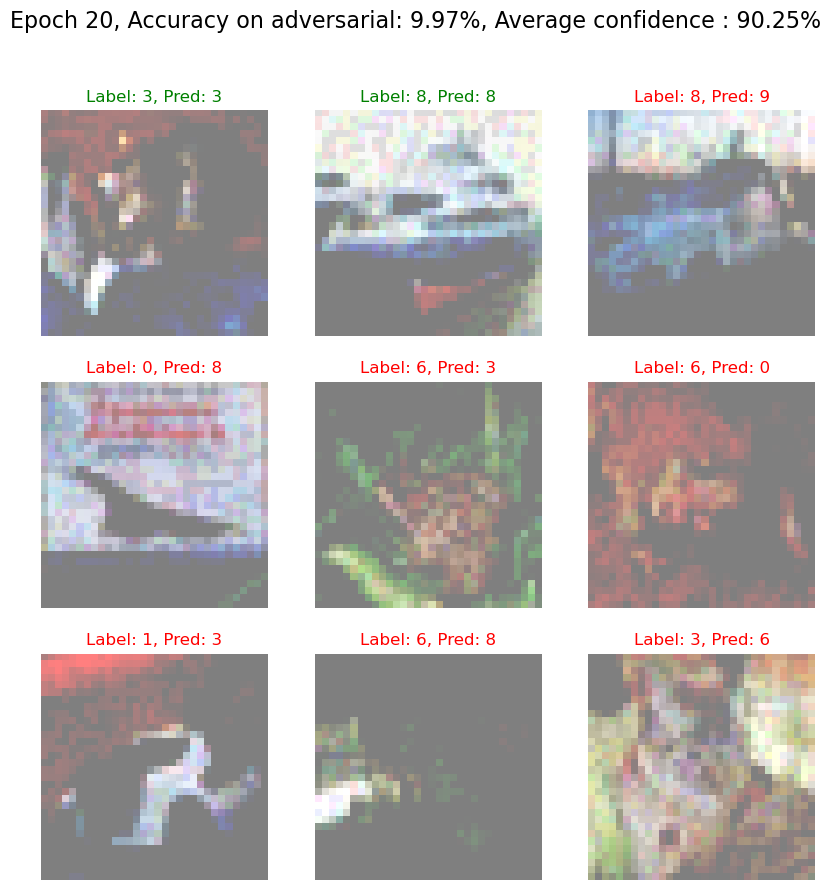

In [34]:
# @title Bonne Version, rnn convolutionnel maxout et données prétraitées de CIFAR-10 avec epsilon = 0.1, et optimisateur : Adam
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Clipper les valeurs des pixels dans [0, 1]

    return adversarial_images

# Modèle CNN avec Maxout (modification du modèle pour utiliser Maxout)
class ConvMaxoutNet(nn.Module):
    def __init__(self):
        super(ConvMaxoutNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*8*8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.maxout = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.maxout(x)
        x = torch.relu(self.conv2(x))
        x = self.maxout(x)
        x = x.view(-1, 64*8*8)  # Aplatir les données
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Charger les données CIFAR-10
def load_data():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, test_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, test_loader, epsilon):
    model.eval()

    correct = 0
    total = 0
    incorrect_probs = []  # Liste pour stocker les probabilités des mauvaises prédictions

    for images, labels in test_loader:
        adversarial_images = FGSM(model, images, labels, epsilon)

        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)  # Convertir les sorties en probabilités
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collecter les probabilités des mauvaises prédictions
        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:  # Si la prédiction est incorrecte
                incorrect_probs.append(probs[i, predicted[i]].item())

    # Calcul de la précision
    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')

    # Calcul de la probabilité moyenne des mauvaises prédictions
    if incorrect_probs:
        avg_incorrect_prob = np.mean(incorrect_probs)*100
        print(f'Average probability assigned to incorrect predictions: {avg_incorrect_prob:.2f}%')
    else:
        avg_incorrect_prob = 0
        print('No incorrect predictions to calculate average probability.')

    return accuracy, avg_incorrect_prob

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)  # Revert normalization
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%, Average confidence : {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.1  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    # Charger les données CIFAR-10
    train_loader, test_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = ConvMaxoutNet()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy, avg_incorrect_prob = test_on_adversarial_data(model, test_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Loss: 1.523592886717423
Epoch [2/20], Loss: 1.0606354821063673
Epoch [3/20], Loss: 0.8563758623417076
Epoch [4/20], Loss: 0.6997542423970254
Epoch [5/20], Loss: 0.5520726561431994
Epoch [6/20], Loss: 0.41100072712087266
Epoch [7/20], Loss: 0.2781102589576903
Epoch [8/20], Loss: 0.17691840851188773
Epoch [9/20], Loss: 0.10737294884746337
Epoch [10/20], Loss: 0.07074546213309421
Epoch [11/20], Loss: 0.0445873719643649
Epoch [12/20], Loss: 0.04505436863277412
Epoch [13/20], Loss: 0.028179238198885976
Epoch [14/20], Loss: 0.03492497014382895
Epoch [15/20], Loss: 0.02110793624419238
Epoch [16/20], Loss: 0.013001054182530754
Epoch [17/20], Loss: 0.013954334972163394
Epoch [18/20], Loss: 0.004825267750300768
Epoch [19/20], Loss: 0.001099614760303787
Epoch [20/20], Loss: 0.000491313318314757
Accuracy on adversarial examples: 12.06%
Average probability assigned to incorrect predictions: 89.30


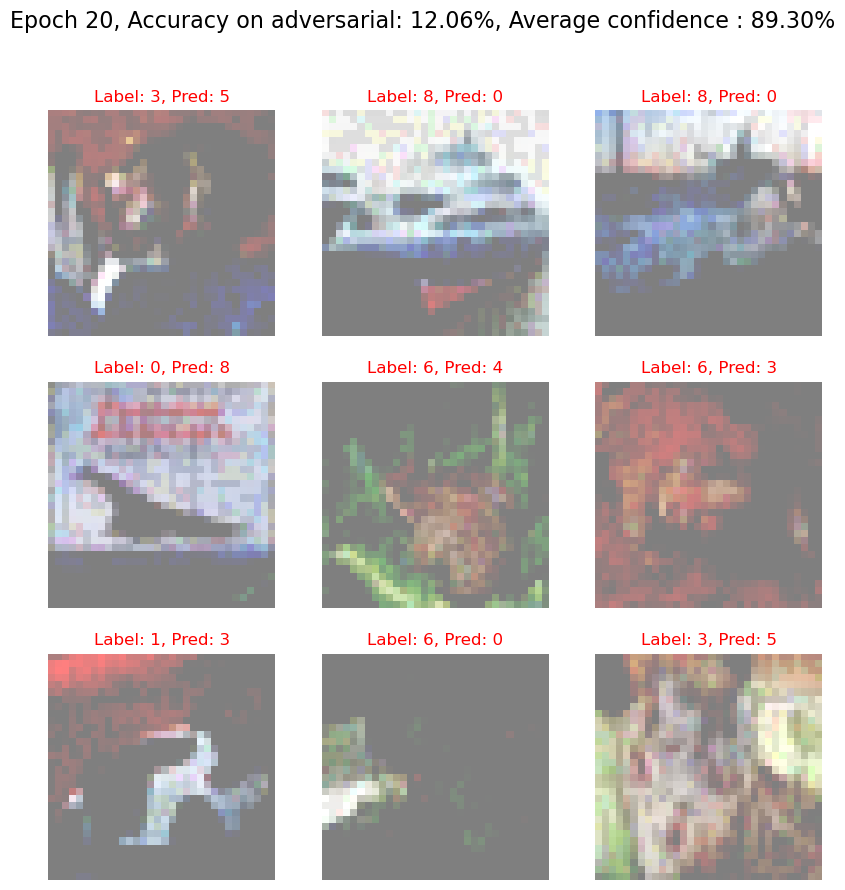

In [40]:
# @title Bonne Version, rnn convolutionnel maxout et données prétraitées de CIFAR-10 avec epsilon = 0.1, et optimisateur : SGD avec momentum (=0.9)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Clipper les valeurs des pixels dans [0, 1]

    return adversarial_images

# Modèle CNN avec Maxout (modification du modèle pour utiliser Maxout)
class ConvMaxoutNet(nn.Module):
    def __init__(self):
        super(ConvMaxoutNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*8*8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.maxout = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.maxout(x)
        x = torch.relu(self.conv2(x))
        x = self.maxout(x)
        x = x.view(-1, 64*8*8)  # Aplatir les données
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Charger les données CIFAR-10
def load_data():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, test_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, test_loader, epsilon):
    model.eval()

    correct = 0
    total = 0
    incorrect_probs = []  # Liste pour stocker les probabilités des mauvaises prédictions

    for images, labels in test_loader:
        adversarial_images = FGSM(model, images, labels, epsilon)

        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)  # Convertir les sorties en probabilités
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collecter les probabilités des mauvaises prédictions
        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:  # Si la prédiction est incorrecte
                incorrect_probs.append(probs[i, predicted[i]].item())

    # Calcul de la précision
    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')

    # Calcul de la probabilité moyenne des mauvaises prédictions
    if incorrect_probs:
        avg_incorrect_prob = np.mean(incorrect_probs) * 100
        print(f'Average probability assigned to incorrect predictions: {avg_incorrect_prob:.2f}')
    else:
        avg_incorrect_prob = 0
        print('No incorrect predictions to calculate average probability.')

    return accuracy, avg_incorrect_prob

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)  # Revert normalization
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%, Average confidence : {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.1  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    # Charger les données CIFAR-10
    train_loader, test_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = ConvMaxoutNet()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy, avg_incorrect_prob = test_on_adversarial_data(model, test_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


## Perturbation adversariale par rotation de x dans la direction du gradient

Note : code à améliorer pour avoir des résultats plus intéressant

 Other simple methods of generating adversarial examples are possible. For example, we also found that rotating x by a small angle in the direction of the gradient reliably produces adversarial examples.

Epoch [1/20], Loss: 0.48160737327166964
Epoch [2/20], Loss: 0.33678642987633056
Epoch [3/20], Loss: 0.3137255366137033
Epoch [4/20], Loss: 0.3020740223607656
Epoch [5/20], Loss: 0.2941311751998691
Epoch [6/20], Loss: 0.2893163056722455
Epoch [7/20], Loss: 0.2839743001088659
Epoch [8/20], Loss: 0.28100347758006694
Epoch [9/20], Loss: 0.2780056922261649
Epoch [10/20], Loss: 0.27553464693110635
Epoch [11/20], Loss: 0.2734516280800549
Epoch [12/20], Loss: 0.27170109481953864
Epoch [13/20], Loss: 0.26991406198281215
Epoch [14/20], Loss: 0.26844109115856035
Epoch [15/20], Loss: 0.2670864041235401
Epoch [16/20], Loss: 0.2659718787539869
Epoch [17/20], Loss: 0.2646420856854364
Epoch [18/20], Loss: 0.26361796636777773
Epoch [19/20], Loss: 0.2626537577247124
Epoch [20/20], Loss: 0.26166121274836535
Accuracy on adversarial examples: 88.03166666666667%
Average probability assigned to incorrect predictions: 65.42%


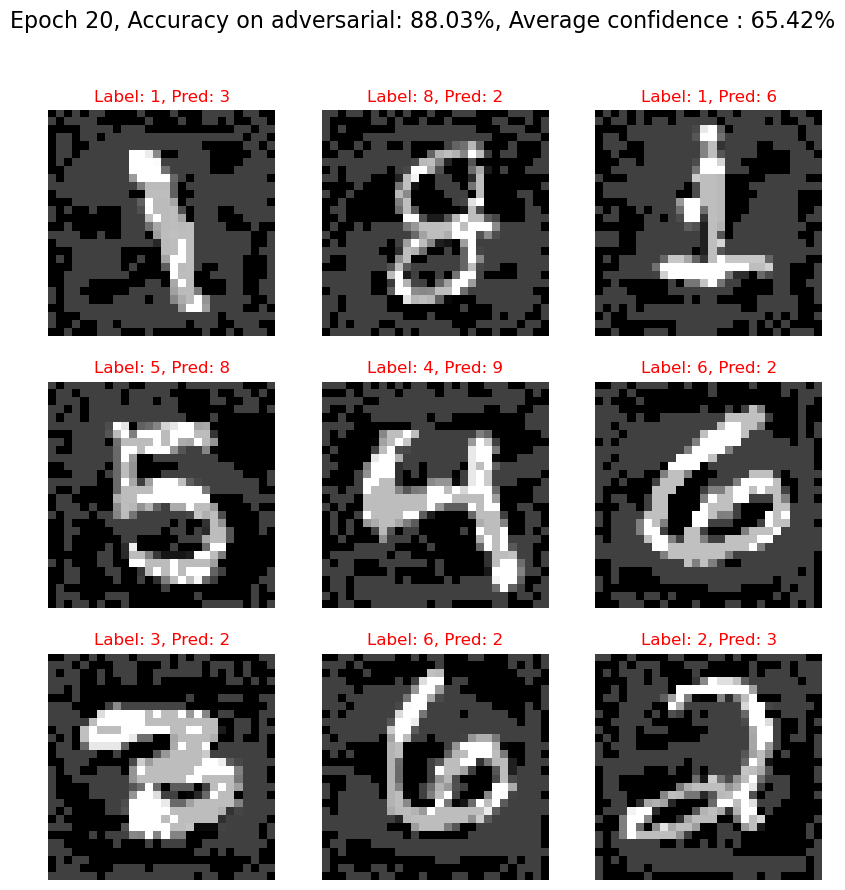

In [ ]:
# @title version test, attaque adversarial par rotation de x dans la direction du gradient
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque adversarial
def rotate_by_gradient(model, images, labels, epsilon):
    # Activer le calcul des gradients pour les images
    images.requires_grad = True

    # Calculer la perte et les gradients
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Calculer le gradient par rapport à l'entrée
    gradients = images.grad

    # Effectuer une "rotation" dans la direction du gradient
    perturbation = epsilon * gradients / gradients.norm(p=2, dim=(1, 2, 3), keepdim=True)
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Clipper les valeurs des pixels dans [0, 1]

    return adversarial_images


# Classe du modèle (shallow softmax classifier)
class ShallowSoftmaxClassifier(nn.Module):
    def __init__(self):
        super(ShallowSoftmaxClassifier, self).__init__()
        # Une seule couche linéaire reliant les pixels d'entrée aux 10 classes
        self.fc = nn.Linear(28 * 28, 10)  # MNIST images de 28x28 pixels

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplatir l'image en vecteur
        x = self.fc(x)
        return x  # Pas de fonction d'activation ici, CrossEntropyLoss inclut softmax
    
# Charger les données MNIST
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()  # Mettre le modèle en mode évaluation

    correct = 0
    total = 0
    incorrect_probs = []

    for images, labels in train_loader:
        # Assurer que les gradients sont activés pour les images
        images = images.clone().detach().requires_grad_(True)

        # Générer des exemples adversaires par rotation
        adversarial_images = rotate_by_gradient(model, images, labels, epsilon)

        # Tester les exemples adversaires
        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)  # Convertir les logits en probabilités
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collecter les probabilités des mauvaises prédictions
        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:
                incorrect_probs.append(probs[i, predicted[i]].item())

    # Calculer les métriques
    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')

    if incorrect_probs:
        avg_incorrect_prob = np.mean(incorrect_probs) * 100
        print(f'Average probability assigned to incorrect predictions: {avg_incorrect_prob:.2f}%')
    else:
        avg_incorrect_prob = 0
        print('No incorrect predictions to calculate average probability.')

    return accuracy, avg_incorrect_prob


# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%, Average confidence : {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    # Charger les données (avec uniquement des 3 et des 7)
    train_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = ShallowSoftmaxClassifier()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy, avg_incorrect_prob = test_on_adversarial_data(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()
